In [1]:
from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.kernels import get_f_Kkappa, get_f_KI, get_f_KILo, apply_window

from tqdm import trange

import sys
zmin = 3.5
zmax = 8.1
Lambda = np.logspace(-5, 0, 50)[18]
chis_resample_len = 13
oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
oup_ILo_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILoKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
print('outputting to', oup_fname)


chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

f_Kkappa = get_f_Kkappa()
a_of_chibs = ccl.scale_factor_of_chi(cosmo, chibs)
z_of_chibs = 1/a_of_chibs - 1


#<I Kappa>
f_KLIM   = get_f_KI()
f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

outputting to /scratch/users/delon/LIMxCMBL/IHiKappa/zmin_3.50000_zmax_8.10000_Lambda_0.00069_chi_sample_2e13.npy


In [2]:
old_chis_resample = np.linspace(10, chimax_sample, 2**13)

In [3]:
window = np.where((old_chis_resample > chimin) & (old_chis_resample < chimax))[0]

In [13]:
log2 = 12
external_chis   = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 2**log2)

####
external_chis = np.linspace(old_chis_resample[window][0], old_chis_resample[window][-1], len(window))
####


ILok = np.zeros((len(ells), len(external_chis)), dtype=np.float64)
external_chis = external_chis.reshape(-1, 1, 1, 1)

In [14]:
chunk = 10
for i in trange(len(external_chis) // chunk + 1):
    idx_left = i * chunk
    idx_right = min((i+1) * chunk, len(external_chis))
    f_KLIMLo = get_f_KILo(external_chi = external_chis[idx_left:idx_right], Lambda=Lambda)
    f_KLIMLo_windowed = apply_window(f_K = f_KLIMLo,
                                     chimin = chimin,
                                     chimax = chimax)
    ILok[:, idx_left:idx_right] = d_chib_integral(f_KLIMLo_windowed, f_Kkappa).T

100%|██████████| 166/166 [04:27<00:00,  1.61s/it]


In [15]:
oup_ILo_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILoKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
old_ILok = np.load(oup_ILo_fname)

In [16]:
vb = np.max(np.abs(ILok))

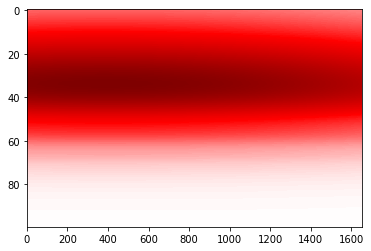

In [17]:
plt.imshow(ILok, aspect='auto', vmin = -vb, vmax = vb, cmap= 'seismic')

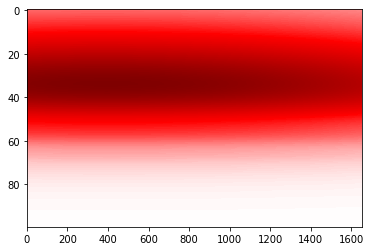

In [18]:
plt.imshow(old_ILok[:,window], aspect='auto', vmin = -vb, vmax = vb, cmap= 'seismic')

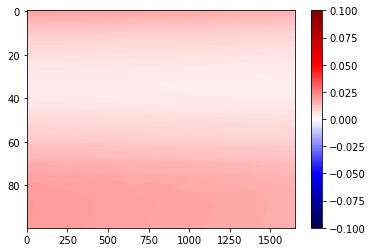

In [24]:
frac_diff = (ILok-old_ILok[:,window])/ILok
plt.imshow(frac_diff, aspect='auto', vmin = -1e-1, vmax = 1e-1, cmap= 'seismic')
plt.colorbar()

In [26]:
print(np.abs(np.max(frac_diff)))

0.01963022664802161


In [28]:
#agrees better than 2% which is good enough for the point we are trying to make